In [1]:
import certifi
import time
import datetime
import requests
import numpy as np
import pandas as pd
import urllib3
import MySQLdb
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
# set up db connection
db = MySQLdb.connect(host="localhost",    
                     user="root",        
                     passwd="root",  
                     db="pipa_db")
cur = db.cursor()

## 1. Extract and parse data from PubMed using a crawler

In [37]:
# set up extraction variables
dailyMax = 200
batchNum = 20
sleeptimeforPubmed = 5
backstep = 20

cur.execute('select pmid from articles order by pmid desc')
rows = cur.fetchall()
# startingPMID = rows[backstep][0]
# endingPMID = rows[0][0]

# for testing
startingPMID = 28334039

print "Starting PMID is %d" % startingPMID

Starting PMID is 28334039


In [38]:
# Main extraction loop
# cur.execute('truncate table articles')
print "Start extracting ..."
for i in range (startingPMID, startingPMID + dailyMax, batchNum):
    
    # Build extraction url
    PMIDs = ""
    for j in range (batchNum):
        PMIDs = PMIDs + str(i + j ) +","
    url = "https://www.ncbi.nlm.nih.gov/pubmed/"+ PMIDs +"?report=medline&format=text"
    
    # Extract data and clean up non-unicode
    time.sleep(sleeptimeforPubmed) # sleep 5 sec between extraction batches
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
    r = http.request('GET', url)
    soup = BeautifulSoup(r.data, "lxml")
    allInfo = unicode(soup.pre.string)

    # Parse data to fetch PMID, Title, Abstract (data are messy -- wrapped with try-except)
    if allInfo.find('PMID- ') < 0:
        print url
        print 'No new data found.'
        break
    
    contentOffset = 6
    while (allInfo.find('AB  -') > 0 and allInfo.find('TI  -') > 0):
        IdIndexStart = allInfo.index('PMID- ') + contentOffset
        IdIndexEnd = allInfo.index('\n', IdIndexStart)
        PMID = allInfo[IdIndexStart:IdIndexEnd]

        try:
            tiIndexStart = allInfo.index('TI  -') + contentOffset
            if allInfo.find('PG  -', tiIndexStart) > 0:
                tiIndexEnd = allInfo.index('PG  -', tiIndexStart) - 1
            elif allInfo.find('LID -', tiIndexStart) > 0:
                tiIndexEnd = allInfo.index('LID -', tiIndexStart) - 1
            else:
                tiIndexEnd = allInfo.index('AB  -', tiIndexStart) - 1
            ti = allInfo[tiIndexStart:tiIndexEnd]
        except:
            ti =""

        abIndexStart = allInfo.index('AB  -') + contentOffset
        try:
            abIndexEnd = allInfo.index('FAU -', abIndexStart) - 1
        except:
            abIndexEnd = abIndexStart + 1000
        ab = ti + "        Abstract:" + allInfo[abIndexStart:abIndexEnd]
        
        # load data into the Articles table in MySQL db
        insert_articles_sql = "insert into articles (pmid, abstract) values ("+ PMID +", '"+ ab + "')"
        try:
            cur.execute(insert_articles_sql)
            db.commit()
        except:
            db.rollback()
        
        endingPMID = int(PMID)
        if (endingPMID % 10 == 0):
            print "%d extracted" % endingPMID
        allInfo = allInfo[abIndexEnd:]
    
now = datetime.datetime.now()
insert_last_pmid_sql = 'insert into last_pmid (record_date, pmid) values ("%s", %d)' % (now, endingPMID)
try:
    cur.execute(insert_last_pmid_sql)
    db.commit()
except:
    db.rollback()
    
print "Extraction and loading completed: PMID %d ~ %d" % (startingPMID, endingPMID) 

Start extracting ...
28334040 extracted
28334050 extracted
28334060 extracted
28334070 extracted
28334080 extracted
28334090 extracted
28334110 extracted
28334120 extracted
28334130 extracted
28334140 extracted
28334150 extracted
28334160 extracted
28334170 extracted
28334180 extracted
28334190 extracted
28334200 extracted
28334210 extracted
28334220 extracted
28334230 extracted
28334240 extracted
28334250 extracted
28334260 extracted
28334270 extracted
28334280 extracted
28334290 extracted
28334310 extracted
28334320 extracted
28334330 extracted
28334340 extracted
28334350 extracted
28334360 extracted
28334370 extracted
28334380 extracted
28334390 extracted
28334400 extracted
28334410 extracted
28334420 extracted
28334430 extracted
28334440 extracted
28334450 extracted
28334470 extracted
28334480 extracted
28334490 extracted
28334500 extracted
28334510 extracted
28334520 extracted
28334530 extracted
28334540 extracted
28334550 extracted
28334560 extracted
28334570 extracted
28334600 e

## 2. Train the recommendation engine

In [39]:
def import_data_articles(table_name, cur):
    """
    Import article data from a table in MySQL db and load them into a pandas Dataframe.
    
    :type table_name: str
    :type cur: db cursor
    :rtype: pandas DataFrame
    """
    #ds = pd.read_csv(data_source)
    ds = cur.execute('select pmid, abstract from ' + table_name)
    r = cur.fetchall()
    return pd.DataFrame(list(r),columns=['PMID', 'abstract'])

In [40]:
def import_user_articles(userId, cur):
    """
    Import a user's articles given id and load them into a pandas Dataframe.
    
    :type table_name: str
    :type cur: db cursor
    :rtype: pandas DataFrame
    """
    
    cur.execute('select pmid, title, abstract from user_articles where user_id=%d'% (userId))
    r = cur.fetchall()
    userdata= pd.DataFrame(list(r),columns=['PMID', 'title', 'abstract'])
    userdata['abstract'] = userdata['title']+'        Abstract:'+userdata['abstract']
    userpool = userdata[['PMID', 'abstract']]
    return userpool

In [41]:
def import_recommend_articles(table_name, cur):
    """
    Import recommend articles from a table in MySQL db and load them into a pandas Dataframe.
    
    :type table_name: str
    :type cur: db cursor
    :rtype: pandas DataFrame
    """
    
    ds = cur.execute('select source_pmid, title_1, title_2, title_3, title_4, title_5, \
    score_1, score_2, score_3, score_4, score_5 from %s order by entry_date desc limit 3' % table_name)
    r = cur.fetchall()
    colnames = ['Source_PMID', 'title_1', 'title_2', 'title_3', 'title_4', 'title_5', \
                'score_1', 'score_2', 'score_3', 'score_4', 'score_5']
    
    return pd.DataFrame(list(r),columns=colnames)

In [106]:
def plot_matrix(matrix):
    """
    Plot a colored heatmap for a given DataFrame with numerical values.

    :type matrix: pandas DataFrame
    :rtype: void
    """

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_aspect('equal')
    ax.grid(False)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.yticks(range(matrix.shape[0]))
    plt.colorbar()
    plt.show()

In [64]:
def train(userpool, dailypool, userId, cur, db):
    """
    Find the top 10 similar articles for each entry in the user's list and write into database
    
    :type userpool: pandas DataFrame
    :type dailypool: pandas DataFrame
    :type userId: int
    :type cur: db cursor
    :type db: MySQL db
    :rtype: void
    """
    
    ds = pd.concat([userpool, dailypool])
    ds.reset_index(drop=True, inplace=True)

    # clean up not ASCII chars
    ds['abstract'] = ds["abstract"].apply(lambda x: ''.join([" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))

    # calculate term frequency
    tf = TfidfVectorizer(analyzer='word',
                         ngram_range=(1, 3),
                         min_df=0,
                         stop_words='english')
    tfidf_matrix = tf.fit_transform(ds['abstract'])

    # calculate similarity of papers(from users and pools) based on term frequency matrix
    cosine_similarities = linear_kernel(tfidf_matrix[:userpool.shape[0]], tfidf_matrix[userpool.shape[0]:])
    similarities = pd.DataFrame(cosine_similarities)

    prediction_matrix = pd.DataFrame(data=userpool.PMID, columns=['PMID'], index=userpool.index)
    similarity_scores = prediction_matrix.copy()
    abstract_matrix = prediction_matrix.copy()

    top_n = 12
    if (ds.shape[0] < top_n):
        top_n = ds.shape[0] + 1

    for i in range(1,top_n-1):
        col_name = i
        prediction_matrix[col_name] = None
        similarity_scores[col_name] = -1
        abstract_matrix[col_name] = None

    now = datetime.datetime.now()

    for idx in range(userpool.shape[0]):
        
        #         sort papers by their similarity score
        print "idx: %s" % idx
        similar_indices = cosine_similarities[idx].argsort()[:-top_n:-1]
        
        # retrive the ID and abstract of sorted papers
        print "similar indices: %s" % similar_indices
        similar_items = [[cosine_similarities[idx][i], ds['PMID'][i+userpool.shape[0]], ds['abstract'][i+userpool.shape[0]]] for i in similar_indices]
        
        # save top 10 hits into MySQL database
        for i in range(0,top_n-1):
            prediction_matrix.ix[idx, i] = similar_items[i][1] # insert into db directly
            similarity_scores.ix[idx, i] = similar_items[i][0] # insert into a db table with date

            titleEnd = similar_items[i][2].index('        Abstract:')           
            similar_items[i][2] = similar_items[i][2][:titleEnd][:200].replace('\"', ' ')

        query = 'insert into recommend_articles (\
        entry_date, user_id, source_pmid,\
        pmid_1, pmid_2, pmid_3, pmid_4, pmid_5, pmid_6, pmid_7, pmid_8, pmid_9,pmid_10, \
        score_1, score_2, score_3,score_4, score_5, score_6, score_7, score_8, score_9, score_10,\
        title_1, title_2, title_3, title_4, title_5, title_6, title_7, title_8, title_9, title_10 ) \
        values \
        ("%s", %d, %d,\
            %d, %d, %d, %d, %d,\
            %d, %d, %d, %d, %d,\
            %.6f,%.6f,%.6f,%.6f,%.6f,\
            %.6f,%.6f,%.6f,%.6f,%.6f,\
            "%s","%s","%s","%s","%s",\
            "%s","%s","%s","%s","%s")'\
        %(now, userId,userpool.ix[idx,'PMID'],\
         similar_items[0][1],similar_items[1][1],similar_items[2][1],\
         similar_items[3][1],similar_items[4][1],similar_items[5][1],\
         similar_items[6][1],similar_items[7][1],similar_items[8][1],\
         similar_items[9][1],\
         similar_items[0][0],similar_items[1][0],similar_items[2][0],\
         similar_items[3][0],similar_items[4][0],similar_items[5][0],\
         similar_items[6][0],similar_items[7][0],similar_items[8][0],\
         similar_items[9][0],\
         similar_items[0][2],similar_items[1][2],similar_items[2][2],\
         similar_items[3][2],similar_items[4][2],similar_items[5][2],\
         similar_items[6][2],similar_items[7][2],similar_items[8][2],\
         similar_items[9][2])
        # print query
        try:
            cur.execute(query)
            db.commit()
        except:
            db.rollback()
    return (similarities, prediction_matrix, similarity_scores);

In [65]:
dailypool = import_data_articles('dev_articles', cur)
dailypool.head()

,PMID,abstract
0,28336258,A comparison of combined intravenous and topic...
1,28336272,Apigenin-7-diglucuronide protects retinas agai...
2,28336275,Structural characterization of purine nucleosi...
3,28336276,Chitin extraction from blue crab (Portunus seg...
4,28336277,Structure characteristics of an acidic polysac...


In [67]:
cur.execute('select distinct user_id from user_articles')
userIdlist = cur.fetchall()

In [68]:
# Train the recommendation engine, build similarity matrix

start = time.time()
for id in userIdlist:
    userpool = import_user_articles(id[0], cur)       
    similarities, prediction_matrix, similarity_scores = train(userpool, dailypool, id[0], cur, db)
    
print("Engine trained in %s seconds." % (time.time() - start))

idx: 0
similar indices: [201 538 203 233 774 234 672 687 405 748 235]
idx: 1
similar indices: [210 219 209 356 357 450 129 186 662  85 772]
idx: 2
similar indices: [208 207 203 202 201 748 156  67 768 365 763]
Engine trained in 3.2585940361 seconds.


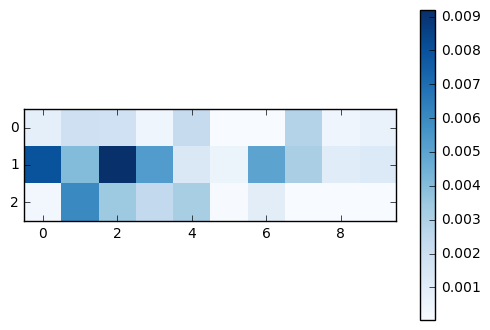

In [107]:
plot_matrix(similarities.iloc[:,:10])

In [69]:
prediction_matrix

,PMID,1,2,3,4,5,6,7,8,9,10
0,28222492,28334332,28345606,28336806,28334835,28336807,28334634,28334655,28334112,28334734,28336808
1,21981078,28336774,28129393,28334040,28334041,28334183,28336489,28336596,28334623,28336413,28334833
2,28256519,28255205,28345606,28346428,28222492,28334734,28336548,28336377,28334815,28334049,28334804


In [70]:
similarity_scores

,PMID,1,2,3,4,5,6,7,8,9,10
0,0.081584,0.062029,0.059382,0.052871,0.041059,0.037835,0.036725,0.034676,0.033675,0.033379,0.032671
1,0.165672,0.115543,0.098835,0.032476,0.026318,0.023308,0.020776,0.020357,0.019525,0.018915,0.018894
2,0.090254,0.064536,0.036856,0.032887,0.028632,0.026362,0.026241,0.024035,0.023209,0.022635,0.022177


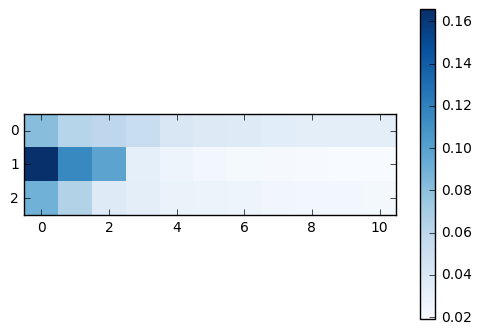

In [108]:
plot_matrix(similarity_scores)

In [72]:
userpool

,PMID,abstract
0,1,p53 regulates mitochondrial respiration ...
1,2,Inhibition of host vacuolar H+-ATPase activity...
2,3,Autophagy and metabolism Abstract:Autop...


In [78]:
recommendations = import_recommend_articles('recommend_articles', cur)
recommendations

,Source_PMID,title_1,title_2,title_3,title_4,title_5,score_1,score_2,score_3,score_4,score_5
0,1,Discovery of Mieap-regulated mitochondrial qua...,Ultraminiature optical design for multispectra...,53BP1 contributes to regulation of autophagic ...,Fluorouracil enhances photodynamic therapy of ...,Screening utilization among cancer survivors: ...,0.081584,0.062029,0.059382,0.052871,0.041059
1,2,Manipulation of host vesicular trafficking and...,In situ structure of the Legionella Dot/Icm ty...,A Legionella Effector Disrupts Host Cytoskelet...,Macrophage origin limits functional plasticity...,Virus-mediated suppression of host non-self re...,0.165672,0.115543,0.098835,0.032476,0.026318
2,3,Autophagy down regulates pro-inflammatory medi...,The Autophagy Level Is Increased in the Synovi...,53BP1 contributes to regulation of autophagic ...,Autophagy is required for cell survival under ...,Discovery of Mieap-regulated mitochondrial qua...,0.090254,0.064536,0.036856,0.032887,0.028632


### Summary

* Crawl publication resources from Pubmed with urllib3
* Parsing information on the webpage with beautifulsoup4
* Calculate similarity with sklearn TF-IDF algorithm
* Read and write data accessing MySQL database

### What's next

* Scale up to more data sources
* Improve recommendation accuracy
* Include collaborative filtering
* Add more features to front-end
